# Imports & Settings

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image
import PIL
import numpy as np
import torchvision
from torchvision import transforms
import os
from torch.utils.data import Dataset
import torch.nn as nn
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Hyperparameters
learning_rate = 0.0003
num_epochs = 10
batch_size = 10
in_channels = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data

In [ ]:
!unzip "/content/drive/MyDrive/CustomDataset.zip"

Archive:  /content/drive/MyDrive/CustomDataset.zip
   creating: CustomDataset/
   creating: CustomDataset/CustomDataset/
  inflating: CustomDataset/CustomDataset/image1.jpg  
  inflating: CustomDataset/CustomDataset/image10.jpg  
  inflating: CustomDataset/CustomDataset/image100.jpg  
  inflating: CustomDataset/CustomDataset/image101.jpg  
  inflating: CustomDataset/CustomDataset/image102.jpg  
  inflating: CustomDataset/CustomDataset/image103.jpg  
 extracting: CustomDataset/CustomDataset/image104.jpg  
  inflating: CustomDataset/CustomDataset/image105.jpg  
  inflating: CustomDataset/CustomDataset/image106.jpg  
  inflating: CustomDataset/CustomDataset/image108.jpg  
  inflating: CustomDataset/CustomDataset/image109.jpg  
  inflating: CustomDataset/CustomDataset/image11.jpg  
  inflating: CustomDataset/CustomDataset/image110.jpg  
  inflating: CustomDataset/CustomDataset/image111.jpg  
  inflating: CustomDataset/CustomDataset/image12.jpg  
  inflating: CustomDataset/CustomDataset/ima

In [ ]:
def to_tensor_and_normalize(imagepil): 
    ChosenTransforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=0, std=1), torchvision.transforms.Resize((128, 128))])
    return ChosenTransforms(imagepil)
    

class Objects(Dataset):
    def __init__(self, root_dir):
        super(Objects, self).__init__()
        self.root_dir = root_dir
        self.all_filenames = os.listdir(root_dir)
    
    def __len__(self):
        return len(self.all_filenames)
        
    def __getitem__(self, idx):
        selected_filename = self.all_filenames[idx]
        imagepil = PIL.Image.open(os.path.join(self.root_dir, selected_filename)).convert('RGB')
        
        image = to_tensor_and_normalize(imagepil)
        
        return image

In [ ]:
dt = Objects("/content/CustomDataset/CustomDataset/")
train_loader = DataLoader(dataset= dt,       
                          batch_size=batch_size, 
                          shuffle=True,
                          )

# Checking the dataset
for images in train_loader:  
    print(images.shape)
    break

torch.Size([10, 3, 128, 128])


# Model

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.dist_dim = latent_dim
        self.encoder = nn.Sequential(
            #128x128x3
                nn.Conv2d(in_channels, 16, stride=(1, 1), kernel_size=(3, 3), padding=1),#128x128x16
                nn.LeakyReLU(0.01),
                nn.Conv2d(16, 32, stride=(2, 2), kernel_size=(3, 3), padding=1),#64x64x32
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),#32x32x64
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),#32x32x64
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(65536, self.dist_dim)
        self.z_log_var = torch.nn.Linear(65536, self.dist_dim)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(self.dist_dim, 65536),
                Reshape(-1, 64, 32, 32),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 16, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(16, in_channels, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  
                nn.Sigmoid()
                )

    def encoding(self, x, genImgs):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = []
        for i in range(genImgs):
          encoded.append(self.sampling(z_mean, z_log_var)) 
        return encoded
        
    def sampling(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.size(0), z_mean.size(1)).cuda().float()
        z = z_mean + eps * torch.exp(z_log_var/2.0) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.sampling(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded


In [ ]:
def loss_fn(model, num_epochs, train_loader, optimizer):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    for epoch in range(num_epochs):

        model.train()
        for batch_idx, imgs in enumerate(train_loader):

            imgs = imgs.cuda().float()
            encoded, z_mean, z_log_var, decoded = model(imgs)
            kl = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), axis=1) 
            batchsize = kl.size(0)
            kl = kl.mean() 

            reconstructionLoss = F.mse_loss(decoded, imgs, reduction='none')
            reconstructionLoss = reconstructionLoss.view(batchsize, -1).sum(axis=1) 
            reconstructionLoss = reconstructionLoss.mean()
            
            loss = reconstructionLoss + kl
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
            if not batch_idx % 10:
                print("epoch", epoch)
                print("loss: ", loss)
                print("Re_loss: ", reconstructionLoss)
                print("kl: ", kl)

In [ ]:
model = VAE(7)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)


In [ ]:
loss_fn(model.cuda().float(), 25, train_loader, optimizer)

epoch 0
loss:  tensor(4221.0459, device='cuda:0', grad_fn=<AddBackward0>)
Re_loss:  tensor(4221.0444, device='cuda:0', grad_fn=<MeanBackward0>)
kl:  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0
loss:  tensor(5954.2891, device='cuda:0', grad_fn=<AddBackward0>)
Re_loss:  tensor(5951.4155, device='cuda:0', grad_fn=<MeanBackward0>)
kl:  tensor(2.8735, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 1
loss:  tensor(5641.0278, device='cuda:0', grad_fn=<AddBackward0>)
Re_loss:  tensor(5634.6055, device='cuda:0', grad_fn=<MeanBackward0>)
kl:  tensor(6.4221, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 1
loss:  tensor(5638.0635, device='cuda:0', grad_fn=<AddBackward0>)
Re_loss:  tensor(5631.7554, device='cuda:0', grad_fn=<MeanBackward0>)
kl:  tensor(6.3081, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 2
loss:  tensor(4687.3369, device='cuda:0', grad_fn=<AddBackward0>)
Re_loss:  tensor(4672.4648, device='cuda:0', grad_fn=<MeanBackward0>)
kl:  tensor(14.8723, device='cud

In [ ]:
torch.save(model, "/content/modelVAE.pt")

In [ ]:
imgs = next(iter(train_loader))
saved = model.encoding(imgs.cuda().float(), 12)
reImages =model.decoder(saved[0])

# Results

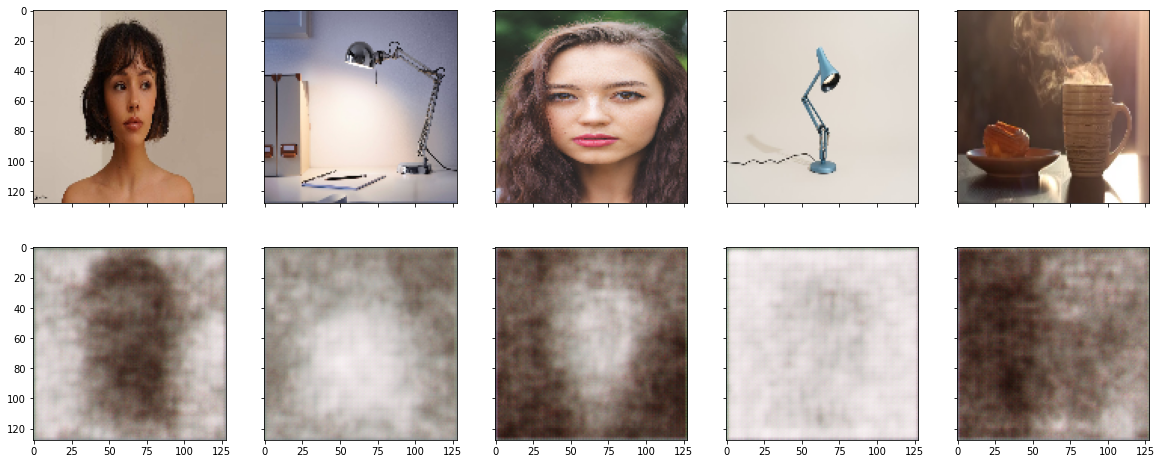

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


##########################
### VISUALIZATION
##########################

n_images = 5
image_width = 128

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 8))
orig_images = imgs[:n_images]
decoded_images = reImages[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images,]):
        cpu_img = img[i].detach().to(torch.device('cpu'))
        
        ax[i].imshow(cpu_img.permute(1, 2, 0))

In [ ]:
#oaded = VAE(7)
Loaded = torch.load("/content/modelVAE.pt")
imgs = next(iter(train_loader))
saved = Loaded.encoding(imgs.cuda().float(), 1)
reImages =model.decoder(saved[0])